In [245]:
%load_ext autoreload
%autoreload 2

import json


import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

import pyhf
pyhf.set_backend('jax')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model

In [246]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 60],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]},    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [179]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [247]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## HMC

### General Stuff

In [248]:
# Jax-compatible expected data
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

one_vector = np.full(nBins, 1., dtype='float64')

# Gradient list (df/dx_1, ..., df/dx_nBins)
@jax.jit
def vjp_expData(parameters):
    _,back = jax.vjp(processed_expData, parameters)
    return back(one_vector)

### Testing the gradient calculation
Calculating the derivatives by hand for MU and STAT_ERROR ONLY: n_bin = stat_error_n * 55 + mu * 6
- d/dmu = dn_bin1 / dmu + dn_bin2 / dmu + dn_bin3 / dmu = 6 + 6 + 60 = 72
- d/dstat_error_1 = dn_bin1 / dstat_error_1 + dn_bin2 / dstat_error_1 + dn_bin3 / dstat_error_1 = 55 + 0 +0
- d/dstat_error_2 = ... = 0 + 55 + 0
- d/dstat_error_3 = ... = 0 + 0 + 55

-> Looks right: (72, 55, 55, 55)

In [226]:
# Testing   
ev_point = model.config.suggested_init()

    # Using my functions
# print(f'processed_expData(ev_point): {processed_expData(ev_point)}')
# print(f'vjp_expData(ev_point): {np.asarray(vjp_expData(ev_point)[0])}')

# print('.......')

    # By hand (attention, the jaconian is shape-inverted)
# print(f'jax.jacrev(processed_expData)(ev_point) @ one_vector: {jax.jacrev(processed_expData)(ev_point) @ one_vector}')

processed_expData(ev_point): [ 61.  61. 115.]
vjp_expData(ev_point): [72. 55. 55. 55.]
.......
jax.jacrev(processed_expData)(ev_point) @ one_vector: [72. 55. 55. 55.]


### Testing the order of the gradients and the order of the parameters

-> Also look good

In [239]:
# order of gradients is order of model.config.suggested_init()
# print(model.config.suggested_init())
# print(model.config.par_map.items())
# print(prior_dict)
# print(prepare_inference.get_target(model))

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dict_items([('corr_bkg', {'slice': slice(0, 1, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x15011df40>}), ('corr_bkg1', {'slice': slice(1, 2, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x1772ec340>}), ('corr_bkg2', {'slice': slice(2, 3, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x178ff05e0>}), ('lumi', {'slice': slice(3, 4, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x17ad9c130>}), ('mu', {'slice': slice(4, 5, None), 'paramset': <pyhf.parameters.paramsets.unconstrained object at 0x15b07ed90>}), ('uncorr_bkg', {'slice': slice(5, 8, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_poisson object at 0x1693d18b0>}), ('uncorr_bkg1', {'slice': slice(8, 11, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_poisson object at 0x1693d1640>}), ('uncor

### Gradient Op

In [249]:
class VJPOp(pt.Op):

    def make_node(self, parameters):
        # self.vjp_func = vjp_expData
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]
        
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters,) = inputs
        results = vjp_expData(parameters)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

### Non-Gradient Op (with `grad` method)

In [250]:
class ExpDataOp(pt.Op):
    
    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    def grad(self, parameters):
        return [vjp_op(parameters)]
        
expData_op = ExpDataOp()

In [192]:
# pytensor.gradient.verify_grad(expData_op, ((ev_point,),), rng=np.random.default_rng())

### Sampling

In [260]:
mu = []
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(pars).eval(), sigma=1, observed=obs)
    
    # step = pm.HamiltonianMC()
    post_data = pm.sample(1500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(post_pred, var_names="ExpData")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals, Gammas]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 2 seconds.


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[ 61.  61. 115.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],37.241,1.005,35.420,39.159,0.013,0.009,6101.0,5654.0,1.0
ExpData[1],22.647,0.993,20.723,24.438,0.013,0.009,6034.0,6000.0,1.0
ExpData[2],96.948,0.973,95.098,98.756,0.013,0.009,5975.0,5935.0,1.0


## Metropolis-Hasting

In [252]:
MetrHast_post_data, MetrHast_post_pred, MetrHast_prior_pred = MH_inference.sampling(prepared_model, 500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(MetrHast_post_pred, var_names="ExpData")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[ 61.  61. 115.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],61.189,1.468,58.321,63.700,0.061,0.043,572.0,1222.0,1.01
ExpData[1],60.690,1.447,57.990,63.308,0.060,0.043,575.0,1175.0,1.00
ExpData[2],115.057,1.429,112.442,117.789,0.054,0.038,713.0,1127.0,1.01


## Plotting

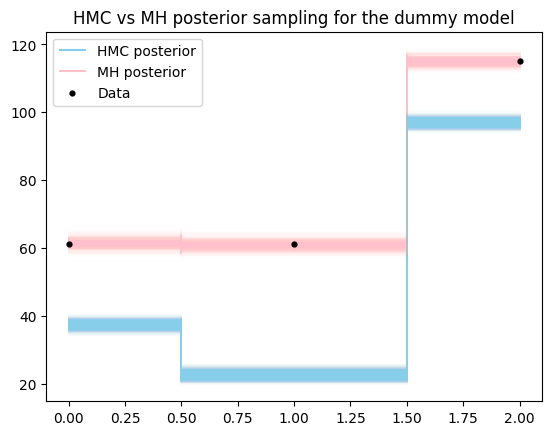

In [261]:
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='HMC prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'skyblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'skyblue', label='HMC posterior')

plt.step(np.linspace(0,nBins-1,nBins),MetrHast_post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(MetrHast_post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='MH posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "Data")
plt.legend(loc='upper left')

plt.title(f'HMC vs MH posterior sampling for the dummy model')
# plt.title(f'HMC vs MH posterior sampling for ttbar')

plt.savefig(f'HMC_MH_dummy')
# plt.savefig(f'HMC_MH_ttbar')
plt.show()

## Inference Quality

In [ ]:
# az.plot_trace(post_data)
# plt.savefig("HMC_traces_DisplacedLeptons")
# az.plot_trace(MetrHast_post_data)
# plt.savefig("MH_traces_DisplacedLeptons")

# az.plot_autocorr(post_data)
# plt.savefig("HMC_autocorr_DisplacedLeptons")
# az.plot_autocorr(MetrHast_post_data)
# plt.savefig("MH_autocorr_DisplacedLeptons")

# az.plot_trace(post_data)
# plt.savefig("HMC_traces_dummy")
# az.plot_trace(MetrHast_post_data)
# plt.savefig("MH_traces_dummyr")

# az.plot_autocorr(post_data)
# plt.savefig("HMC_autocorr_dummy")
# az.plot_autocorr(MetrHast_post_data)
# plt.savefig("MH_autocorr_dummy")